### Import required Libraries

In [237]:
import h5py
import requests
import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math, time, itertools
import datetime
from operator import itemgetter

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn import linear_model;
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [238]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model

### Load Dataset

In [249]:
df = pd.read_csv("./dataset/prices-split-adjusted.csv", index_col = 0)

In [250]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [251]:
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [252]:
len(set(df['symbol']))

501

### Select a company for which we'll be predicting stock prices

In [253]:
df = df[df['symbol'] == 'SYMC']
df['Mid']=(df['high']+df['low'])/2
df.sort_values(by='date',inplace=True)

### Prepare Train and Test Dataset

In [254]:
def prepare_data(df,forecast_col,forecast_out,test_size):
    label = df[forecast_col].shift(-forecast_out);
    X = np.array(df[[forecast_col]]); 
    X = preprocessing.scale(X) 
    X_lately = X[-forecast_out:] 
    X = X[:-forecast_out] 
    label.dropna(inplace=True); 
    y = np.array(label) 
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y, test_size=test_size) #cross validation 

    response = [X_train,X_test , Y_train, Y_test , X_lately];
    return response;

### Prepare Dataset and add a new column, Mid = (low + high)/2 to the data

In [255]:
target_col = 'Mid'
predict_window = 20
test_size = 0.2;

X_train, X_test, Y_train, Y_test , X_lately =prepare_data(df, target_col, predict_window, test_size); 

# Model 1: Linear Regression

In [256]:
linear_reg_model = linear_model.LinearRegression(); 

The test score is:  0.8609059659597256


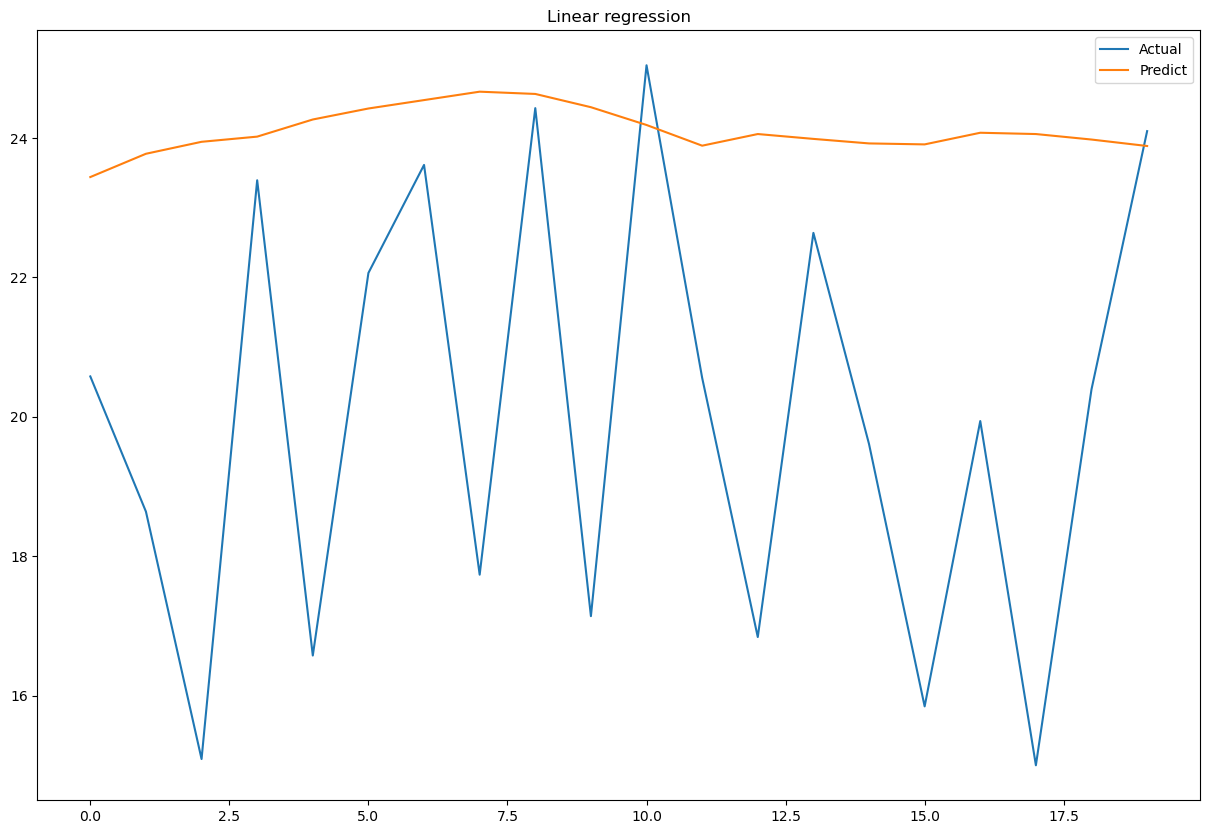

In [258]:
linear_reg_model.fit(X_train,Y_train); 
score = linear_reg_model.score(X_test,Y_test);

predicted= linear_reg_model.predict(X_lately); 

response={};
response['test_score']=score; 
response['predicted_set']=predicted;
print("The test score is: ",format(score))

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)
ax.plot(Y_test[:predict_window],label='Actual')
ax.plot(predicted,label='Predict')
plt.title('Linear regression')
ax.legend()

# Model 2 - Standard Average

### Prepare Dataset

In [259]:
train_start = 0
train_end=df.shape[0]-1
test_start = train_end
n= df.shape[0]
test_end = n
data_train = df.iloc[np.arange(train_start, train_end), :]
data_test = df.iloc[np.arange(test_start, test_end), :]

data_train=data_train.reset_index()
data_test=data_test.reset_index()

scaler = MinMaxScaler()
training_val=scaler.fit_transform(data_train['Mid'].to_numpy().reshape(-1,1))
test_val=scaler.transform(data_test['Mid'].to_numpy().reshape(-1,1))

In [260]:
data_train.head()

,date,symbol,open,close,low,high,volume,Mid
0,2010-01-04,SYMC,18.040001,18.400000,18.010000,18.530001,8322300.0,18.270001
1,2010-01-05,SYMC,18.400000,18.299999,18.139999,18.440001,6621200.0,18.290000
2,2010-01-06,SYMC,18.219999,18.360001,18.139999,18.459999,6043600.0,18.299999
3,2010-01-07,SYMC,18.469999,18.320000,18.129999,18.469999,8085300.0,18.299999
4,2010-01-08,SYMC,18.250000,18.370001,18.209999,18.500000,6030900.0,18.354999


In [261]:
window_size = 75
N = training_val.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.index.values[pred_idx]

    std_avg_predictions.append(np.mean(training_val[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-training_val[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00594


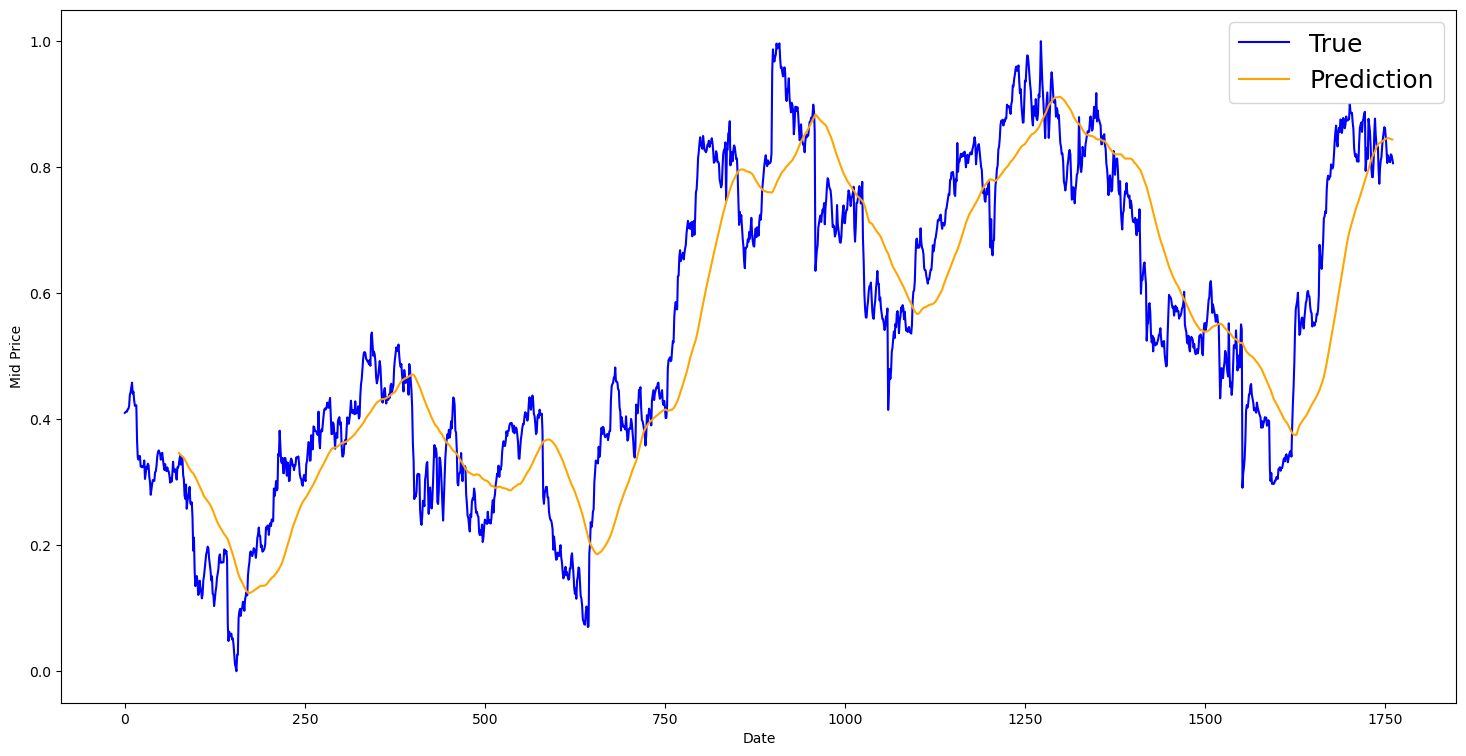

In [262]:
all_mid_data = np.concatenate([training_val,test_val],axis=0)
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

# Model 3 - Exponential moving average

In [265]:
window_size = 100
N = training_val.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*training_val[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-training_val[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00032


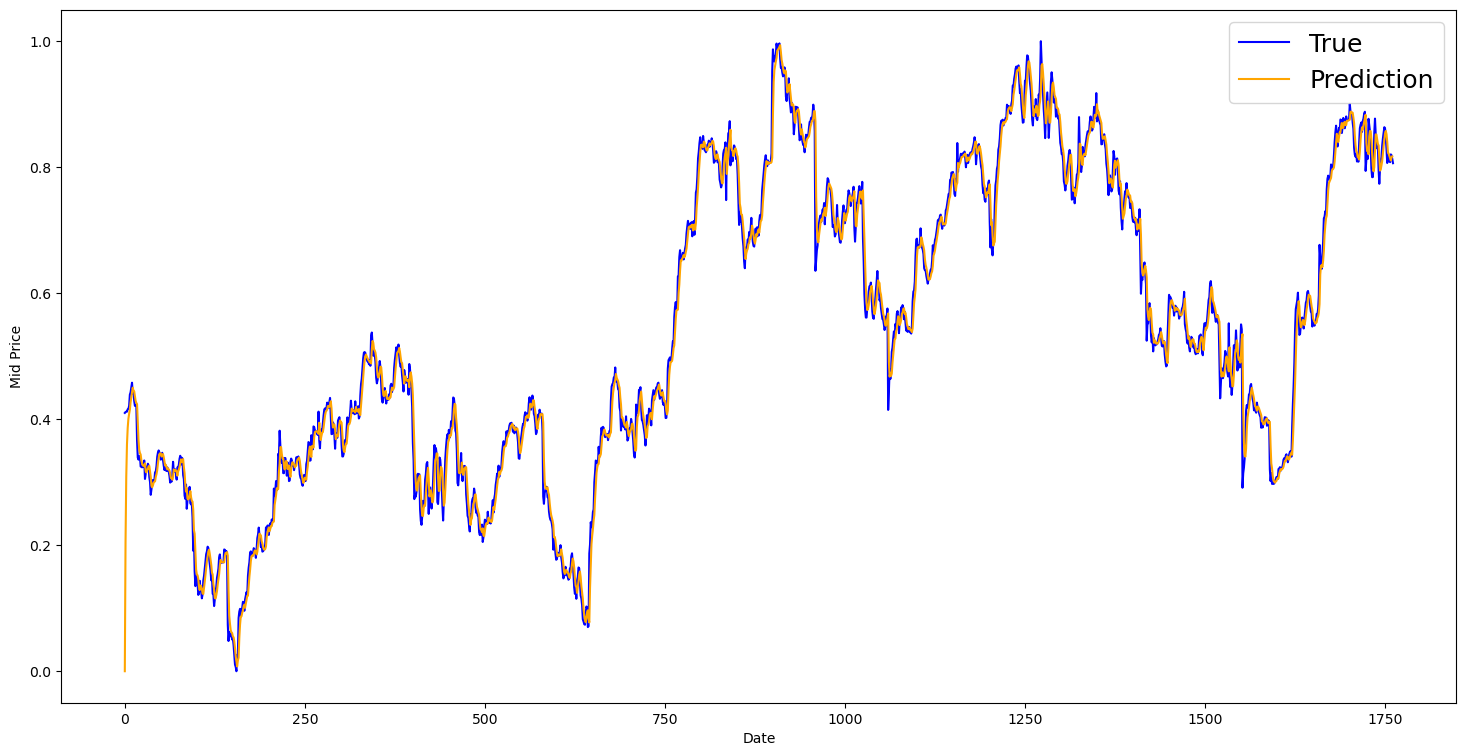

In [266]:
all_mid_data = np.concatenate([training_val,test_val],axis=0)
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

# Model 4 - LSTM

### Preparing Data

In [199]:
train_start = 0
train_end = 1000
test_start = train_end
test_end = n
data_train = df.iloc[np.arange(train_start, train_end), :]
data_test = df.iloc[np.arange(test_start, test_end), :]

data_train=data_train.reset_index()
data_test=data_test.reset_index()
scaler = StandardScaler()
training_val=scaler.fit_transform(data_train['Mid'].to_numpy().reshape(-1,1))
test_val=scaler.transform(data_test['Mid'].to_numpy().reshape(-1,1))

### Plotting Train and Test Data

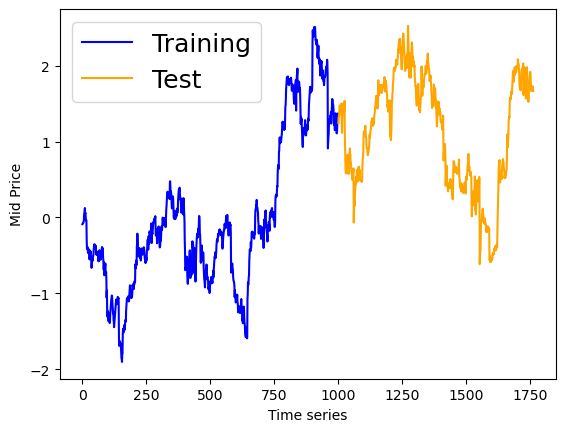

In [200]:
plt.plot(range(0,training_val.shape[0]),training_val,color='b',label='Training')
plt.plot(range(training_val.shape[0],training_val.shape[0]+test_val.shape[0]),test_val,color='orange',label='Test')
plt.xlabel('Time series')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
# plt.title(Company_select)
plt.show()

### In this model, we are predicting the stock price of current date from the data of last n days (n=50)

In [223]:
training_set=data_train['Mid'].to_numpy().reshape(-1,1)
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
ndays = 50
X_train = []
y_train = []
for i in range(ndays, train_end):
    X_train.append(training_set_scaled[i-ndays:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

### LSTM Model

In [232]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=60, return_sequences=False, input_shape=(X_train.shape[1],1)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')

In [233]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 60)                14880     
                                                                 
 dropout_7 (Dropout)         (None, 60)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 61        
                                                                 
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [234]:
model.fit(X_train,y_train,epochs=4,batch_size=128,verbose=2)

Epoch 1/4
8/8 - 6s - loss: 0.5479 - 6s/epoch - 808ms/step
Epoch 2/4
8/8 - 1s - loss: 0.1350 - 649ms/epoch - 81ms/step
Epoch 3/4
8/8 - 1s - loss: 0.0926 - 599ms/epoch - 75ms/step
Epoch 4/4
8/8 - 1s - loss: 0.0658 - 605ms/epoch - 76ms/step


### Predict on Test Dataset

In [235]:
dataset_total = pd.concat((data_train['Mid'], data_test['Mid']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(data_test) - ndays:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(ndays, n-train_end+ndays):
    X_test.append(inputs[i-ndays:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

24/24 [==============================] - 2s 20ms/step


### Plotting the predicted values

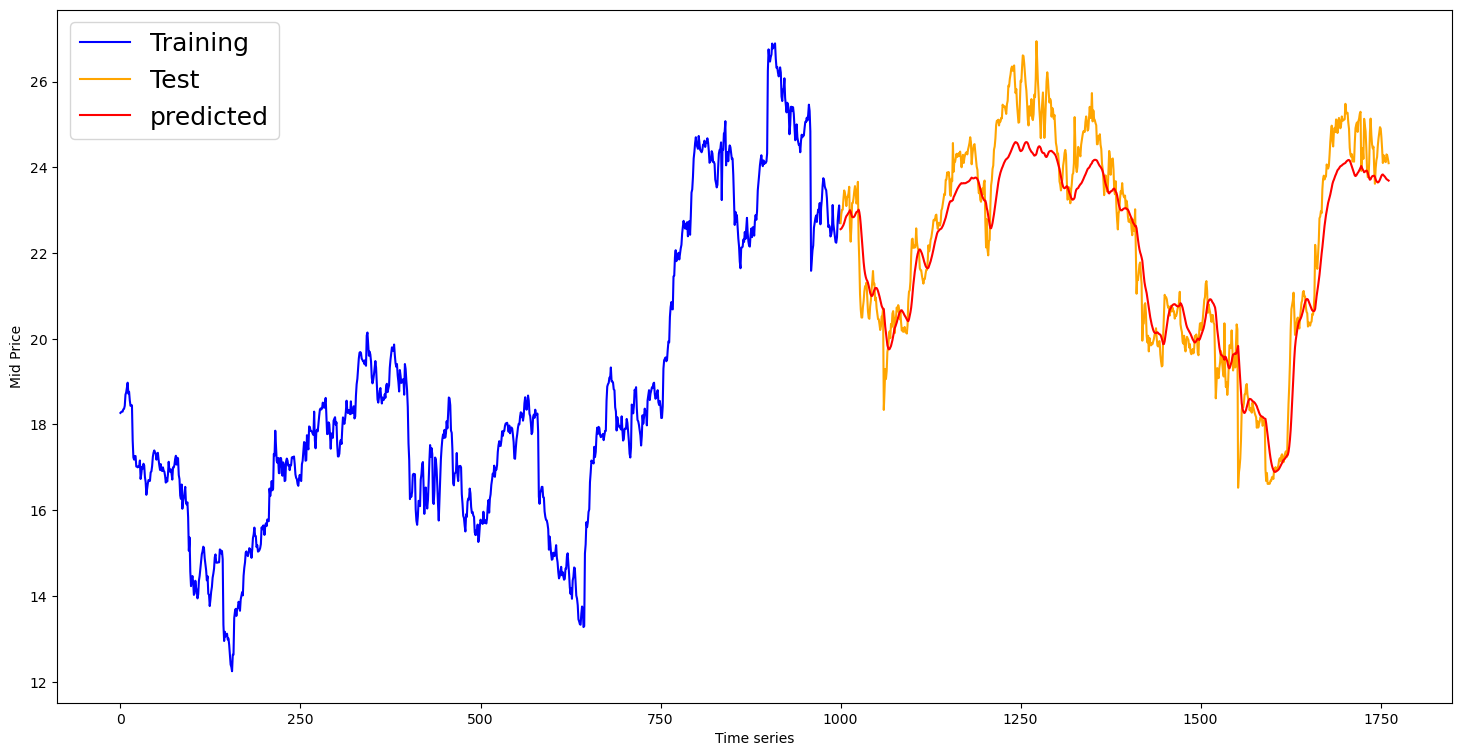

MSE: [0.6698808]


In [236]:
plt.figure(figsize = (18,9))
plt.plot(range(0,training_val.shape[0]),data_train['Mid'].to_numpy().reshape(-1,1),color='b',label='Training')
plt.plot(range(training_val.shape[0],training_val.shape[0]+test_val.shape[0]),data_test['Mid'].to_numpy().reshape(-1,1),color='orange',label='Test')
plt.plot(range(training_val.shape[0],training_val.shape[0]+predicted_stock_price.shape[0]),predicted_stock_price,color='red',label='predicted')
plt.xlabel('Time series')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
# plt.title(Company_select)
plt.show()
mse = ((predicted_stock_price - data_test['Mid'].to_numpy().reshape(-1,1))**2).mean(axis=0)
print('MSE: {}'.format(mse))